In [1]:
import numpy as np
import pandas as pd
from pcap_analysis import *

crawl_data_dir = '/mnt/iot-house/crawl-data/amazon-data-20190401-121138'
post_process_dir = join(crawl_data_dir, 'post-process')



In [2]:
#Create Timestamp DF
channel_timestamps = load_timestamp_json(crawl_data_dir)
df_ch_timestamps = pd.DataFrame(channel_timestamps).transpose().reset_index()
df_ch_timestamps.rename(columns={'index': 'Channel Name'}, inplace=True)

#Generate Global (All SSL/TCP Streams)
global_df = gen_global_df(post_process_dir)

#Add SSL artifacts 
global_df_ssl = add_ssl_features(global_df, post_process_dir)
#Drop all duplicates
global_df_ssl = global_df_ssl.drop_duplicates(subset=['Channel Name', 'ip.dst', 'MITM Attemp',  'SSL Failure'])
print(global_df.head())

Loading timestamp data from /mnt/iot-house/crawl-data/amazon-data-20190401-121138
Generating Global DF from /mnt/iot-house/crawl-data/amazon-data-20190401-121138/post-process 
Adding SSL features to DF from /mnt/iot-house/crawl-data/amazon-data-20190401-121138/post-process 
   tcp.stream  frame.time_epoch      ip.src         ip.dst  \
0           8      1.554170e+09  10.42.0.20   72.21.206.56   
1           9      1.554170e+09  10.42.0.20   72.21.206.56   
2          10      1.554170e+09  10.42.0.20  52.94.227.120   
3          13      1.554170e+09  10.42.0.20  52.46.132.145   
4          18      1.554170e+09  10.42.0.20  54.239.26.246   

           Channel Name  MITM Attemp  SSL Failure  
0  com.hiveview.damaitv            0            0  
1  com.hiveview.damaitv            0            0  
2  com.hiveview.damaitv            0            0  
3  com.hiveview.damaitv            1            1  
4  com.hiveview.damaitv            1            1  


In [3]:
######Timestamp Analysis######
##############################

#Merge global_df with timestamp_df
global_df_merged = pd.merge(global_df_ssl, df_ch_timestamps, on=['Channel Name'])
global_df_merged['epoch'] = np.nan

epoch_list = list(df_ch_timestamps)
epoch_list.remove('Channel Name')


#Populate epoch column for channel based on
#the timestamp of SYN packet.
for epoch in epoch_list:
    global_df_merged['epoch'] = np.where(global_df_merged['frame.time_epoch']>global_df_merged[epoch],
                                     epoch, global_df_merged['epoch'])

#print(global_df_merged)


In [4]:
#Graph
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


labels = epoch_list

#Sort Lanuch tries
min_iter = None
max_iter = None
for idx, val in enumerate(epoch_list):
    if 'launch' in val:
        if min_iter == None:
            min_iter = idx
        max_iter = idx + 1

labels[min_iter:max_iter] = sorted(labels[min_iter:max_iter], key=str_to_int_key)
launch_label = labels[min_iter:max_iter]
#print(labels)

new_endpoints_df = global_df_merged.drop_duplicates(subset=['Channel Name', 'ip.dst'])

new_endpoints_count = []
for epoch in labels:
    df_epoch = new_endpoints_df.loc[global_df_merged['epoch'] == epoch]
    total_len = len(df_epoch)
    print( "%s saw %s new end point" % (epoch, str(total_len)) )
    new_endpoints_count.append(total_len)



install_channel saw 95 new end point
launch-1 saw 394 new end point
launch-2 saw 336 new end point
launch-3 saw 78 new end point
launch-4 saw 49 new end point
launch-5 saw 36 new end point
launch-6 saw 35 new end point
launch-7 saw 50 new end point
launch-8 saw 34 new end point
launch-9 saw 72 new end point
launch-10 saw 0 new end point
select-0 saw 125 new end point
select-1 saw 152 new end point
select-2 saw 289 new end point


<IPython.core.display.Javascript object>


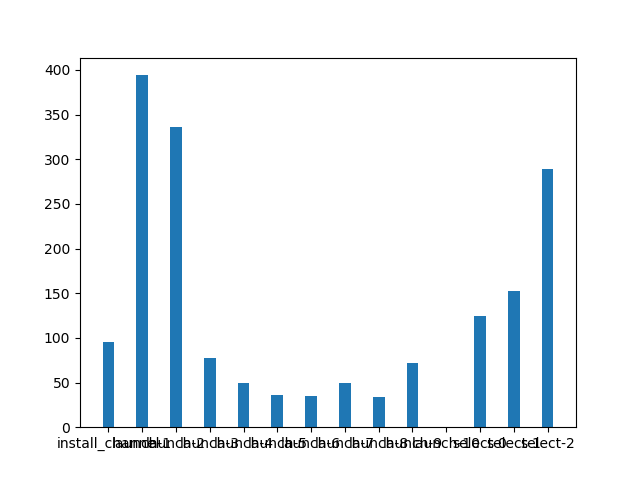

In [5]:
N = len(labels)
ind = np.arange(N)
width = 0.35

plt1 = plt.figure(1)
p1 = plt.bar(ind, new_endpoints_count, width)
plt.xticks(ind, labels);

#plt1.show()

<IPython.core.display.Javascript object>


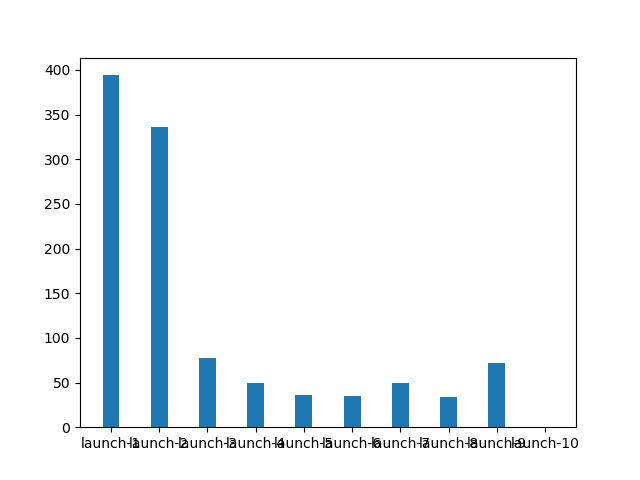

In [6]:
N = len(launch_label)
ind = np.arange(N)
width = 0.35

plt1 = plt.figure(2)
p1 = plt.bar(ind, new_endpoints_count[min_iter:max_iter], width)
plt.xticks(ind, launch_label);

#plt1.show()

<IPython.core.display.Javascript object>


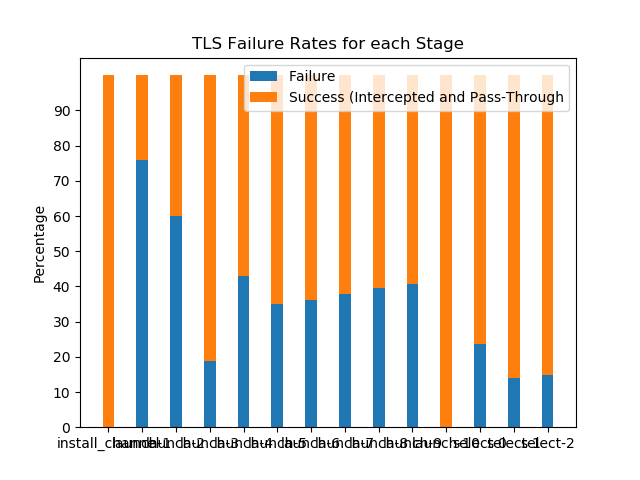

In [7]:
plt2 = plt.figure(3)
labels = epoch_list
failure_percentage = []
success_percentage = []
for epoch in epoch_list:
    df_epoch = global_df_merged.loc[global_df_merged['epoch'] == epoch]
    total_len = len(df_epoch)
    failure_len = len(df_epoch.loc[df_epoch['SSL Failure'] == 1])
    if total_len == 0:
        failure_percent = 0
        success_percent = 100
    else:
        failure_percent = 100 * float(failure_len)/float(total_len)
        success_percent = 100 - failure_percent
    failure_percentage.append(failure_percent)
    success_percentage.append(success_percent)
    #print(failure_percentage)
    #print(success_percentage)
    #print('******')




N = len(epoch_list)
ind = np.arange(N)
width = 0.35


p1 = plt.bar(ind, failure_percentage, width)
p2 = plt.bar(ind, success_percentage, width, bottom=failure_percentage)
plt.xticks(ind, epoch_list)
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('Percentage')
plt.title('TLS Failure Rates for each Stage')
plt.legend((p1[0], p2[0]), ('Failure', 'Success (Intercepted and Pass-Through'));


#plt2.show()
